# ImageClassification-AI: Modelo T 
### **Feature Extraction**

Modelo que faz uso da técnica de transfer learning, Feature Extraction.
Este modelo também irá fazer uso do modelo VGG16.

### 1. Setup

#### 1.1 Importar dependências

Importação das bibliotecas necessárias para o desenvolvimento do modelo.

São de notar as bibliotecas:
* Tensorflow e Keras, que vão ser utilizadas na construção do modelo e no seu processo de treino

* Matplotlib (em específico o pyplot), Seaborn e sklearn, que vão ser utilizadas para facilitar a análise e a compreensão das métricas atribuidas ao modelo, da sua evolução, e dos resultados obtidos

* Image_dataset_from_directory (através do keras.utils), numpy e OS para o carregamento e tratamento dos dados

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers, regularizers, optimizers
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.applications.vgg16 import VGG16

#### 1.2 Desativar warnings do Tensorflow

Para desenvolvimento deste modelo foi utilizada a versão 2.10.0 do Tensorflow. Devido a este facto, ficou compreendido que seria beneficial desativar as mensagens de warning dadas pelo Tensorflow, deixando apenas as mensagens de erro, com o intuito de melhorar substancialmente a legibilidade do notebook. É importante realçar que, nenhuma das mensagens de aviso que serão desativadas, em algum momento afetam qualquer aspeto do modelo ou sequer ajudam a compreender potenciais problemas com este.

In [2]:
tf.get_logger().setLevel('ERROR')

#### 1.3 Tratamento de dados

Definição das classes do problema:

* Tamanho das imagens RGB (32x32x3 pixeis) 
* Tamanho de cada batch (32)
* Diretorias dos datasets de treino, validação e teste

Para a criação dos datasets é utilizado o image_dataset_from_directory com os paramêtros relativos à diretoria onde estão as imagens, o tamanho destas, o tamanho de cada batch, a definição das labels como categorical (requerido devido ao facto do problema em questão envolver 10 classes; as labels serão uma tensor float32 de tamanho (batch_size, num_classes), que iram representar, cada, um one-hot encoding de cada index de cada classe). 

Aqui é, ainda, importar notar:

* O dataset de treino está a ser baralhado de modo a que, durante o processo de treino, o modelo não decore padrões nas imagens de treino. Para além disso, é relevante perceber que o dataset de treino é construido através da concatenação de quatro datasets de treino mais pequenos (cada um relativo a uma das diretoria de treino)

* Os datasets de validação e de testes não são baralhados. Ao baralhar o dataset de treino a análise dos resultados obtidos pelo modelo seria extremamente dificultada (e.g. ao construir um classification report para este dataset os resultados seriam incorretos porque as labels não iriam corresponder) No que toca ao dataset de validação, a questão entre baralhar ou não acaba por ser irrelevante já que não existe nenhum tipo de benefício para o fazer. Isto foi confirmado por uma pesquisa sobre o assunto e por tentativas de treino do modelo com o dataset de validação baralhado e sem estar baralhado (os resultados eram os mesmo)

In [3]:
class_names = []

IMG_SIZE = 224
BATCH_SIZE = 32

train_dirs = ['train1', 'train2', 'train3', 'train5']
val_dir = 'train4'
test_dir = 'test'

print("BUILDING TRAIN DATASET...")

train1_dataset = image_dataset_from_directory(train_dirs[0], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, color_mode='rgb')
train2_dataset = image_dataset_from_directory(train_dirs[1], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, color_mode='rgb')
train3_dataset = image_dataset_from_directory(train_dirs[2], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, color_mode='rgb')
train5_dataset = image_dataset_from_directory(train_dirs[3], image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=True, color_mode='rgb')

print("\nBUILDING VALIDATION DATASET...")
val_dataset = image_dataset_from_directory(val_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False,color_mode='rgb')

print("\nBUILDING TEST DATASET...")
test_dataset = image_dataset_from_directory(test_dir, image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE, label_mode='categorical', shuffle=False, color_mode='rgb')

# Concatenar datasets
train_dataset = train1_dataset.concatenate(train2_dataset)
train_dataset = train_dataset.concatenate(train3_dataset)
train_dataset = train_dataset.concatenate(train5_dataset)

for name in val_dataset.class_names:
    idx = name.index('_') + 1
    class_names.append(name[idx:])

BUILDING TRAIN DATASET...
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.

BUILDING VALIDATION DATASET...
Found 10000 files belonging to 10 classes.

BUILDING TEST DATASET...
Found 10000 files belonging to 10 classes.


#### 1.3 Carregar o modelo VGG16

Carregar o modelo VGG16 para ser, posteriormente, utilizado na construção e processo de treino do modelo.

In [4]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#### 1.4 Calcular as features e labels

##### 1.4.1 Definição da função

Escolhemos utilizar a função que nos foi disponibilizada nas aulas sendo que, apenas foi acrescentado uma indicação relativa ao progresso do calculo.

In [5]:
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    size = len(dataset)
    aux = 1

    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images, batch_size=32)
        all_features.append(features)
        all_labels.append(labels)
        print("step " + str(aux) + "/" + str(size))
        aux += 1

    return np.concatenate(all_features), np.concatenate(all_labels)


##### 1.4.2 Realizar o calculo

Efetuamos os cálculos individualmente para o dataset de treino e, posteriormente, concatenamos as features e labels individuais num só local que iremos utilizar para guardar estas. No caso das features e labels para o dataset de test e validação o problema supramencionado já não irá existir.

In [7]:
# Calcular as features e labels para o dataset de treino
train1_features, train1_labels = get_features_and_labels(train1_dataset)
train2_features, train2_labels = get_features_and_labels(train2_dataset)
train3_features, train3_labels = get_features_and_labels(train3_dataset)
train5_features, train5_labels = get_features_and_labels(train5_dataset)

# Juntar todas as features e labels de treino num só array (para cada)
all_train_features = np.concatenate([train1_features, train2_features, train3_features, train5_features])
all_train_labels = np.concatenate([train1_labels, train2_labels, train3_labels, train5_labels])

# Calcular features e labels do dataset de validação e teste
val_features, val_labels = get_features_and_labels(val_dataset)
test_features, test_labels = get_features_and_labels(test_dataset)

# Guardar as features e labels calculadas
np.save('features/IC_T_FE_train_features.npy', all_train_features)
np.save('labels/IC_T_FE_train_labels.npy', all_train_labels)
np.save('features/IC_T_FE_val_features.npy', val_features)
np.save('labels/IC_T_FE_val_labels.npy', val_labels)
np.save('features/IC_T_FE_test_features.npy', test_features)
np.save('labels/IC_T_FE_test_labels.npy', test_labels)

1/1 [==============================] - 0s 49ms/step
step 1/313
1/1 [==============================] - 0s 29ms/step
step 2/313
1/1 [==============================] - 0s 29ms/step
step 3/313
1/1 [==============================] - 0s 29ms/step
step 4/313
1/1 [==============================] - 0s 28ms/step
step 5/313
1/1 [==============================] - 0s 31ms/step
step 6/313
1/1 [==============================] - 0s 30ms/step
step 7/313
1/1 [==============================] - 0s 29ms/step
step 8/313
1/1 [==============================] - 0s 31ms/step
step 9/313
1/1 [==============================] - 0s 27ms/step
step 10/313
1/1 [==============================] - 0s 29ms/step
step 11/313
1/1 [==============================] - 0s 28ms/step
step 12/313
1/1 [==============================] - 0s 29ms/step
step 13/313
1/1 [==============================] - 0s 28ms/step
step 14/313
1/1 [==============================] - 0s 27ms/step
step 15/313
1/1 [==============================] - 0s 27ms/st

##### 1.4.3 Carregar as features e labels calculadas

Carregar as features e labels calculadas previamente para uso futuro.

In [5]:
# Carregar as features e labels
train_features = np.load('features/IC_T_FE_train_features.npy')
train_labels = np.load('labels/IC_T_FE_train_labels.npy')
validation_features = np.load('features/IC_T_FE_val_features.npy')
validation_labels = np.load('labels/IC_T_FE_val_labels.npy')
test_features = np.load('features/IC_T_FE_test_features.npy')
test_labels = np.load('labels/IC_T_FE_test_labels.npy')

### 2. Visualização

#### 2.1 - Classes e número de imagens

Visualização das classes que envolvem o problema e da quantidade de imagens contidas em cada dataset

In [ ]:
print("\nClasses: " + str(class_names))

total_train = 0
for td in train_dirs:
    class_folders = next(os.walk(td))[1]
    for cf in class_folders:
        total_train += len(os.listdir(os.path.join(td, cf)))

total_val = 0
class_folders = next(os.walk(val_dir))[1]
for folder in class_folders:
    folder_path = os.path.join(val_dir, folder)
    total_val += len(os.listdir(folder_path))

total_test = 0
class_folders = next(os.walk(test_dir))[1]
for folder in class_folders:
    folder_path = os.path.join(test_dir, folder)
    total_test += len(os.listdir(folder_path))

print("Dataset de treino: " + str(total_train) + " imagens")
print("Dataset de validação: " + str(total_val) + " imagens")
print("Dataset de teste: " + str(total_test) + " imagens")


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Dataset de treino: 40000 imagens
Dataset de validação: 10000 imagens
Dataset de teste: 10000 imagens


#### 2.2 Tamanhos

Visualização dos tamanhos:
* Cada batch tem 32 imagens
* Cada imagem RGB tem 32x32 pixeis (32x32x3)
* Cada batch de labels tem 10 classes

In [ ]:
for data_batch, label_batch in train_dataset:
    print('Shape de cada data batch: ', data_batch.shape)
    print('Shape de cada label batch: ', label_batch.shape)
    break

Shape de cada data batch:  (32, 224, 224, 3)
Shape de cada label batch:  (32, 10)


#### 2.3 - Normalização

Visualização da normalização dos pixeis:
* Divisão do valor de cada pixel por 255
* Operação definida, posteriormente, na construção do modelo e, feita durante o processo de treino para cada imagem de modo a que, cada pixel tenha um valor associado que pertença ao intervalo de [0,1].
* Mostrar como o modelo irá interpretar cada imagem (os valores de cada pixel)

In [ ]:
iterator = train_dataset.as_numpy_iterator()
batch = iterator.next()
batch[0] / 255 # normalizar (feito no VGG16)

array([[[[1.        , 0.99607843, 0.99215686],
         [1.        , 0.99607843, 0.99215686],
         [1.        , 0.99607843, 0.99215686],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 0.99607843, 0.99215686],
         [1.        , 0.99607843, 0.99215686],
         [1.        , 0.99607843, 0.99215686],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        [[1.        , 0.99607843, 0.99215686],
         [1.        , 0.99607843, 0.99215686],
         [1.        , 0.99607843, 0.99215686],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],

        ...,

        [[0.9843137 , 0.9843137 , 0.9843137 ],
         [0.9843137 , 0.9843137 , 0.9843137 ]

#### 2.4 - Imagens do dataset de treino

Visualização de dez imagens aleatórias do dataset de treino.

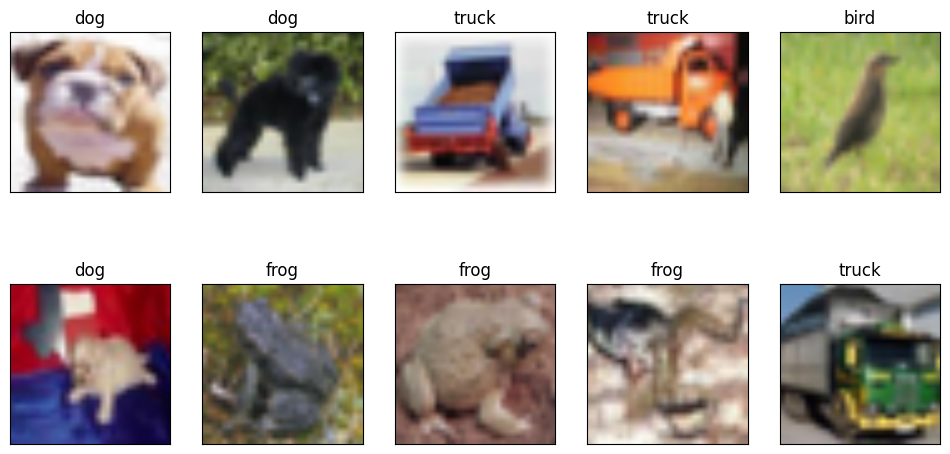

In [ ]:
plt.figure(figsize=(12, 6))  # Aumentar o tamanho das imagens no plot

for data_batch, label_batch in train_dataset.take(1):
    for i in range(10):
        plt.subplot(2, 5, i + 1) # mostrar as imagens todas no "mesmo plot" de modo a economizar espaço
        plt.title(class_names[np.argmax(label_batch[i])]) # mostrar a classe da imagem
        plt.imshow(data_batch[i].numpy().astype('uint8'))
        plt.xticks([]) # não mostrar os eixos (irrelevante para a visualização)
        plt.yticks([]) # não mostrar os eixos (irrelevante para a visualização)
    plt.show()

### 3. Modelo

#### 3.1 Definição do bloco de classificação

Aqui está a ser efetuado a definição da parte relativa a classificação do modelo, estando a parte restante encarregue do modelo VGG16.

É de notar:

* Input_shape de 7x7x512: vai mudar consoante o tamanho das imagens que for escolhido. Como neste caso estamos a utilizar imagens 224x224x3 este é o shape que irá chegar ao bloco de classificação.

* A utilização do Flatten para transformar os valores obtidos até aquele ponto pelo modelo VGG16

* A camada densa com 256 filtros à qual aplicamos a técnica de normalização BatchNormalization de modo a manter consistente a distribuição dos valores. Depois de aplicada esta técnica, é então utilizada a função de ativação ReLu e a técnica de Dropout() com o valor de 0.5, ou seja, vão ser "ignorados" 50% dos neurónios contidos na camada densa.

* É utilizada uma outra camada densa, com 10 filtros, para efetuar a classificação da imagem. Aqui é utilizada a função de ativação "softmax" devido a esta ser mais apropriada a um problema de classificação com várias classes diferentes. Para além disso, é também, utilizado a regularização L2 para, tal como o Dropout, mitigar o overfitting

É feito um sumário do modelo para melhor compreensão deste, especialmente no que toca ao tamanho dos feature maps em cada ponto e à quantidade de paramêtros que este envolve.

In [6]:
inputs = keras.Input(shape=(7,7,512))

x = layers.Flatten()(inputs)

x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)
x = layers.Dropout(0.5)(x)

outputs = layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7, 7, 512)]       0         
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256)               0         
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                             

#### 3.2 Compilação

É utilizada a função de loss "categorical_crossentropy" devido à natureza do problema (várias classes).
Para analisar o desempenho do modelo são utilizadas metricas de acerto (neste caso o "CategorialAccuracy" em vez do Accuracy normal devido ao contexto do problema), precisão e recall. É, ainda, importante referir que inicialmente era para ser incluida uma métrica de calculo relativo ao F1-Score, mas, devido ao facto de ter sido utilizado o Tensorflow 2.10.0 para treinar os modelos, como supramencionado, não foi possível utilizar esta métrica. Isto acontece porque esta versão do Tensorflow não suporta a referida metrica. Realizaram-se experiências utilizando a métrica F1-Score do Tensorflow Addons mas, os resultados não foram satisfatórios.

Nesta modelo S foi utilizado como optimizador o Adam(), com o objetivo de explorar mais optimizadores. Não é definido um learning rate a ser utilizado por este optimizador, sendo utilizado o por omissão, já que esta já possui, de base, técnicas de otimização do learning rate.

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
        ])

#### 3.3 Processo de treino

São definidas callbacks de:
* EarlyStopping, que vai servir para interromper o processo de treino. É monitorizada a loss no dataset de validação em cada epoch e, se após 10 epochs não houver melhoria desta métrica, então o treino vai ser interrompido

* ModelCheckpoint, que vai permitir guardar o melhor modelo obtido durante o processo de treino (em troca de se guardar o modelo na ultima epoch de treino que, pode não ser necessáriamente o melhor como é o caso de, por exemplo, situações onde o modelo começa a entrar em overfitting). Aqui é definida a diretoria onde guardar o melhor modelo e a metrica de monitorização que, neste caso, volta a ser a loss no dataset de validação. É, também utilizado o verbose para melhorar a compreensão do processo de treino.

Com isto, é, então, realizado o processo de treino (model.fit()) utilzando:

* O dataset de treino
* 50 epochs
* O dataset de validação para representar a capacidade de generalização do modelo
* As callbacks de EarlyStopping e ModelCheckpoint definidas

In [8]:
# Definir as callbakcs
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='models/IC_T_FE_training.keras',
        save_best_only = True,
        monitor='val_loss',
        verbose=1
)]

# Treinar o modelo
history = model.fit(train_features, train_labels, epochs=50, validation_data=(validation_features, validation_labels), callbacks=callbacks)

Epoch 1/50
1241/1250 [============================>.] - ETA: 0s - loss: 0.6480 - accuracy: 0.8248 - precision: 0.8833 - recall: 0.7650
Epoch 1: val_loss improved from inf to 0.43656, saving model to models\IC_T_FE_training.keras
1250/1250 [==============================] - 10s 7ms/step - loss: 0.6474 - accuracy: 0.8249 - precision: 0.8832 - recall: 0.7650 - val_loss: 0.4366 - val_accuracy: 0.8895 - val_precision: 0.9280 - val_recall: 0.8454
Epoch 2/50
1248/1250 [============================>.] - ETA: 0s - loss: 0.3641 - accuracy: 0.9111 - precision: 0.9401 - recall: 0.8792
Epoch 2: val_loss improved from 0.43656 to 0.42749, saving model to models\IC_T_FE_training.keras
1250/1250 [==============================] - 9s 7ms/step - loss: 0.3642 - accuracy: 0.9111 - precision: 0.9400 - recall: 0.8791 - val_loss: 0.4275 - val_accuracy: 0.8851 - val_precision: 0.9183 - val_recall: 0.8532
Epoch 3/50
1245/1250 [============================>.] - ETA: 0s - loss: 0.2696 - accuracy: 0.9416 - precisi

#### 3.4 Definição do modelo final

Para construir o modelo final é preciso juntar o bloco de classificação construido previamente, ao modelo VGG16.

In [ ]:
# Carregar o melhor modelo obtido durante o processo de treino
model = keras.models.load_model('models/IC_T_FE_training.keras')

# Criar o modelo final (juntando o modelo treinado com o VGG16)
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = keras.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
outputs = model(x)
final_model = keras.Model(inputs, outputs)

#### 3.5 Compilação do modelo final

Processo semelhante ao anterior (ponto 3.2). É de realçar que foi acrescentado a funcionalidade para guardar o modelo final.

In [ ]:
final_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[
        tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
        tf.keras.metrics.Precision(name="precision"),
        tf.keras.metrics.Recall(name="recall"),
    ])

# Guardar o modelo
final_model.save('models/IC_T_FE.keras')

#### 3.6 Avaliação do modelo final 

O modelo final é carregado e avaliado utilizando o dataset de teste. Aqui é mostrado os valores das métricas de accuracy, loss, precision e recall obtidas pelo modelo nas imagens de teste.

In [ ]:
# Carregar o modelo
model = keras.models.load_model('models/IC_T_FE.keras')

# Avaliar o modelo
test_loss, test_acc, test_precision, test_recall = model.evaluate(test_dataset)

print("Test Accuracy: " + str(test_acc))
print("Test Loss: " + str(test_loss))
print("Test Precision: " + str(test_precision))
print("Test Recall: " + str(test_recall))

313/313 [==============================] - 24s 74ms/step - loss: 0.4230 - accuracy: 0.8854 - precision: 0.9083 - recall: 0.8635
Test Accuracy: 0.8853999972343445
Test Loss: 0.4229614734649658
Test Precision: 0.9082781076431274
Test Recall: 0.8634999990463257


### 4. Análise de resultados

#### 4.1 Evolução das métricas durante o processo de treino

É utilizado gráficos para melhor compreender de que maneira as métricas, nomeadamente a accuracy, loss, precision e recall, foram evoluindo ao longo do processo de treino.

É possível observar que:
* O modelo entra em overfitting quase imediatamente.

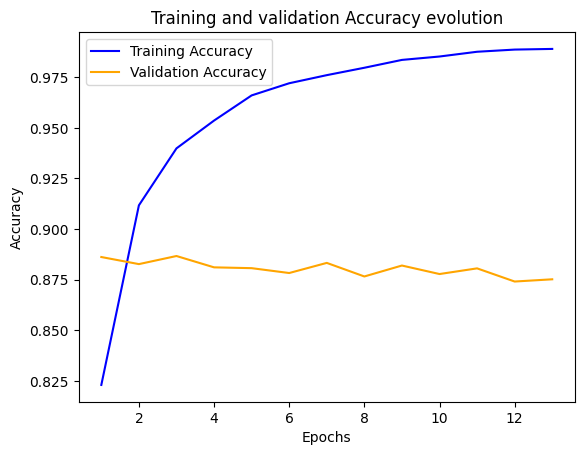

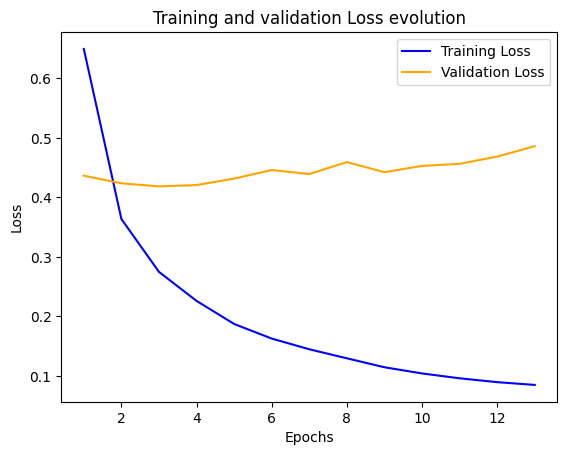

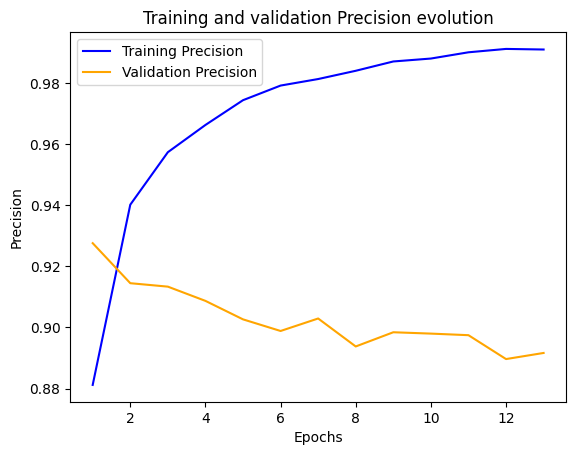

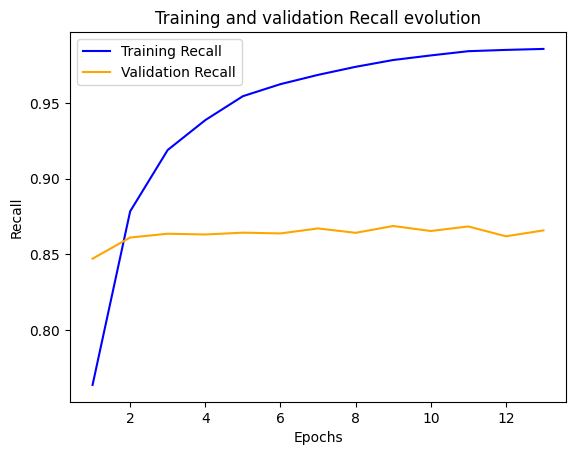

In [ ]:
# Buscar as métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
precision = history.history['precision']
val_precision = history.history['val_precision']
recall = history.history['recall']
val_recall = history.history['val_recall']

# Calcular o número de épocas que foram realizadas
epochs = range(1, len(acc) + 1)

# Gráfico da accuracy
plt.plot(epochs, acc, 'blue', label='Training Accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation Accuracy')
plt.title('Training and validation Accuracy evolution')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()

# Gráfico da loss
plt.plot(epochs, loss, 'blue', label='Training Loss')
plt.plot(epochs, val_loss, 'orange', label='Validation Loss')
plt.title('Training and validation Loss evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.figure()

# Gráfico da precision
plt.plot(epochs, precision, 'blue', label='Training Precision')
plt.plot(epochs, val_precision, 'orange', label='Validation Precision')
plt.title('Training and validation Precision evolution')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.figure()

# Gráfico do recall
plt.plot(epochs, recall, 'blue', label='Training Recall')
plt.plot(epochs, val_recall, 'orange', label='Validation Recall')
plt.title('Training and validation Recall evolution')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.show()

#### 4.2 Desempenho no dataset de teste

De modo a compreender o real desempenho do modelo precisamos avaliar este utilizando o dataset de teste (que contém imagens que o este nunca viu anteriormente).

São feitas, e guardadas, previsões do modelo sobre o dataset de teste para, posteriormente, ser criado um classification report, que nos vai permitir analisar a taxa de acerto global e a precision, recall e f1-score para cada classe. Para além disso, é, também, construida uma matriz de confusão que, vai permitir ilustrar de uma outra maneira as previsões (vai ser possível ver, por exemplo, que quando a imagem pertencia à classe "dog", o modelo achou n vezes que a imagem pertencia à classe "cat").

Com isto, podemos compreender que:

* O modelo obtem resultados satisfatórios

* É de realçar a maior dificuldade do modelo, a classificação com para a classe Dog:

    * É a classe com menos previsões corretas

    * Considerável número de vezes que confude a classe Dog com a Cat 


313/313 [==============================] - 23s 72ms/step
              precision    recall  f1-score   support

    airplane       0.90      0.92      0.91      1000
  automobile       0.96      0.91      0.93      1000
        bird       0.84      0.84      0.84      1000
         cat       0.74      0.82      0.78      1000
        deer       0.84      0.90      0.87      1000
         dog       0.87      0.78      0.82      1000
        frog       0.92      0.91      0.92      1000
       horse       0.95      0.87      0.91      1000
        ship       0.92      0.96      0.94      1000
       truck       0.93      0.94      0.94      1000

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



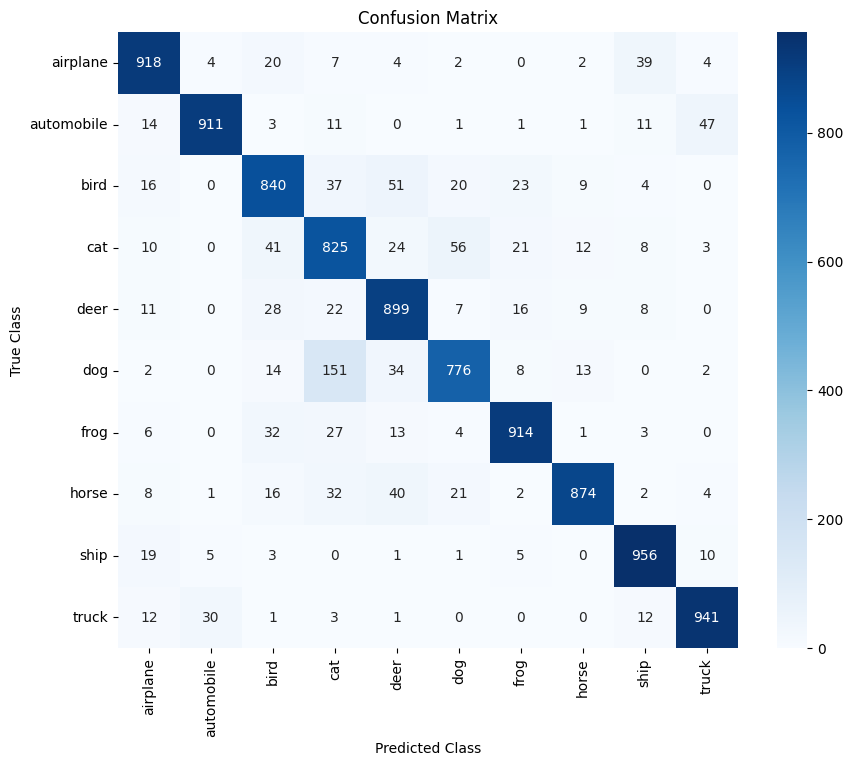

In [ ]:
# Fazer previsões para o dataset de teste
predictions = model.predict(test_dataset)
predicted_classes = np.argmax(predictions, axis=1)

# Obter as classes verdadeiras de cada imagem no dataset de teste
true_classes = []
for images, labels in test_dataset:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))
true_classes = np.array(true_classes)

# Criar o classification report
report = classification_report(true_classes, predicted_classes, target_names=class_names)
print(report)

# Mostrar a matriz de confusão
cm = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

#### 4.3 Visualização de previsões

Aqui fazemos a visualização de imagens tal como anteriormente, mas introduzimos a previsão do modelo para cada uma das imagens, sendo possível visualizar, também, a classe real de cada imagem.#### 4.3 Mostrar 10 previsões

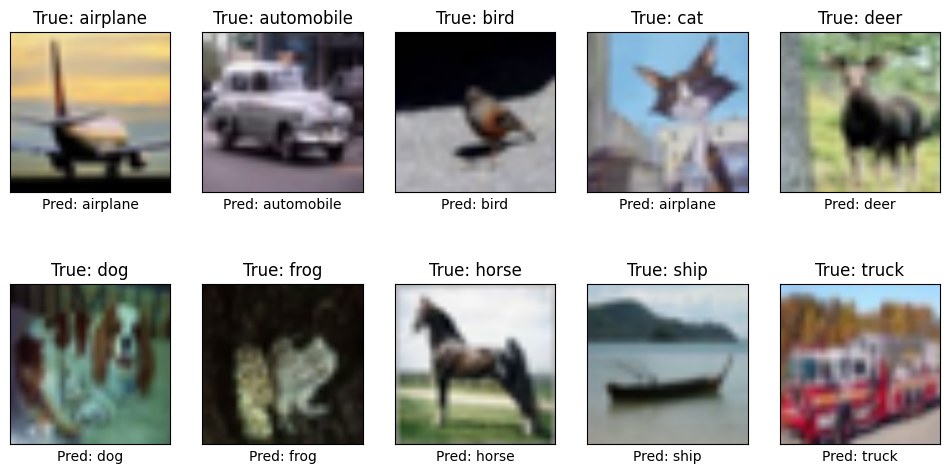

In [ ]:
displayed_classes = set()

plt.figure(figsize=(12, 6))  # Ajustar o tamanho das imagens

for data_batch, label_batch in test_dataset:
    for i in range(len(label_batch)):
        true_class_idx = np.argmax(label_batch[i])
        true_label = class_names[true_class_idx]
        
        if true_class_idx not in displayed_classes:
            displayed_classes.add(true_class_idx)
            
            plt.subplot(2, 5, len(displayed_classes))
            
            pred_label = model.predict(np.expand_dims(data_batch[i], axis=0), verbose=0)
            pred_label = class_names[np.argmax(pred_label)]

            plt.title("True: " + true_label)
            plt.xlabel("Pred: " + pred_label)
            plt.imshow(data_batch[i].numpy().astype('uint8'))
            plt.xticks([])
            plt.yticks([])
        
        # Stop condition para no caso de já terem sido mostrada 10 imagens
        if len(displayed_classes) == 10:
            break
    if len(displayed_classes) == 10:
        break

plt.show()

### Conclusões

O modelo sofre de overfitting. Isto é aparente pela obsevação dos gráficos apresentados no ponto 4.1. É de notar que o intervalo do eixo das ordenadas no gráfico é pequeno, o que, numa observação superfícial, vai fornecer a ideia de que o problema é muito maior do que realmente é.

É de prespectivar que ao aplicar operações de Data Augmentation o problema será, na sua maioria, resolvido. Existem outras opções para resolver este problema como, por exemplo, técnicas de regularização que, poderam fazer parte de uma futura experiência que tenha o intuito de melhorar o modelo.

### Bibliografia

https://www.markdownguide.org/basic-syntax/

https://www.tensorflow.org/

https://keras.io/api/applications/

https://keras.io/api/optimizers/

https://keras.io/api/data_loading/

https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

https://nchlis.github.io/2017_08_10/page.html

https://towardsdatascience.com/a-guide-to-an-efficient-way-to-build-neural-network-architectures-part-ii-hyper-parameter-42efca01e5d7